# GRL(DANN) implementation using PaSST feature extractor on DCASE Dataset


In [7]:
import torch
import torchvision
import torch.nn as nn

In [8]:
torch.__version__

'2.7.0+cu126'

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [10]:
import numpy as np
import datetime
import os, sys

In [11]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [12]:
MODEL_NAME = 'DANN'
print("cuda") if torch.cuda.is_available() else print("cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [13]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )

    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [14]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

In [15]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=512, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_classes),
            nn.Sigmoid(),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

In [16]:
F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)
D = Discriminator().to(DEVICE)

In [17]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [18]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:02<00:00, 4.48MB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 124kB/s]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:07<00:00, 234kB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 7.48MB/s]


In [21]:
svhn_train = datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='../data/', split='test', transform=transform, download=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64.3M/64.3M [00:06<00:00, 9.92MB/s]


In [22]:
batch_size = 64

In [23]:
svhn_train.data.shape

(73257, 3, 32, 32)

In [24]:
svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [25]:
bce = nn.BCELoss()
xe = nn.CrossEntropyLoss()

In [26]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())
D_opt = torch.optim.Adam(D.parameters())

In [27]:
max_epoch = 100
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lamda = 0.01

In [28]:
D_src = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_tgt = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake
D_labels = torch.cat([D_src, D_tgt], dim=0)

### Training Code



In [29]:
def get_lambda(epoch, max_epoch):
    p = epoch / max_epoch
    return 2. / (1+np.exp(-10.*p)) - 1.

In [30]:
# Initialize global MNIST iterator
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    try:
        return next(mnist_set)
    except StopIteration:
        mnist_set = iter(mnist_loader)
        return next(mnist_set)

step = 0
ll_c = []
ll_d = []
acc_lst = []

for epoch in range(1, max_epoch + 1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)

        # Move data to device
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)

        # Train Discriminator
        x = torch.cat([src, tgt], dim=0)
        h = F(x)
        y = D(h.detach())
        Ld = bce(y, D_labels)

        D.zero_grad()
        Ld.backward()
        D_opt.step()

        # Train Feature Extractor and Classifier
        c = C(h[:batch_size])
        y = D(h)
        Lc = xe(c, labels)
        Ld = bce(y, D_labels)

        lamda = 0.1 * get_lambda(epoch, max_epoch)
        Ltot = Lc - lamda * Ld

        F.zero_grad()
        C.zero_grad()
        D.zero_grad()
        Ltot.backward()
        C_opt.step()
        F_opt.step()

        # Logging
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print(f'Epoch: {epoch}/{max_epoch}, Step: {step}, D Loss: {Ld.item():.4f}, '
                  f'C Loss: {Lc.item():.4f}, lambda: {lamda:.4f} ---- {dt}')
            ll_c.append(Lc.item())
            ll_d.append(Ld.item())

        # Evaluation
        if step % 500 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(eval_loader.dataset)
                print(f'***** Eval Result: {acc:.4f}, Step: {step}')

                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print(f'***** Test Result: {acc:.4f}, Step: {step}')
                acc_lst.append(acc)

            F.train()
            C.train()

        step += 1


Epoch: 1/100, Step: 0, D Loss: 0.6120, C Loss: 2.3188, lambda: 0.0050 ---- 16:52:29
***** Eval Result: 0.0683, Step: 0
***** Test Result: 0.1010, Step: 0
Epoch: 1/100, Step: 100, D Loss: 0.0002, C Loss: 2.2926, lambda: 0.0050 ---- 16:52:40
Epoch: 1/100, Step: 200, D Loss: 0.2332, C Loss: 2.0371, lambda: 0.0050 ---- 16:52:45
Epoch: 1/100, Step: 300, D Loss: 0.0923, C Loss: 2.1202, lambda: 0.0050 ---- 16:52:50
Epoch: 1/100, Step: 400, D Loss: 0.3665, C Loss: 2.0212, lambda: 0.0050 ---- 16:52:55
Epoch: 1/100, Step: 500, D Loss: 0.5892, C Loss: 2.0568, lambda: 0.0050 ---- 16:53:01
***** Eval Result: 0.3003, Step: 500
***** Test Result: 0.2138, Step: 500
Epoch: 1/100, Step: 600, D Loss: 0.5909, C Loss: 2.0570, lambda: 0.0050 ---- 16:53:11
Epoch: 1/100, Step: 700, D Loss: 0.7132, C Loss: 1.8866, lambda: 0.0050 ---- 16:53:17
Epoch: 1/100, Step: 800, D Loss: 0.4176, C Loss: 1.7492, lambda: 0.0050 ---- 16:53:22
Epoch: 1/100, Step: 900, D Loss: 0.7724, C Loss: 1.8444, lambda: 0.0050 ---- 16:53:2

## Visualize Sample

In [31]:
import matplotlib.pyplot as plt

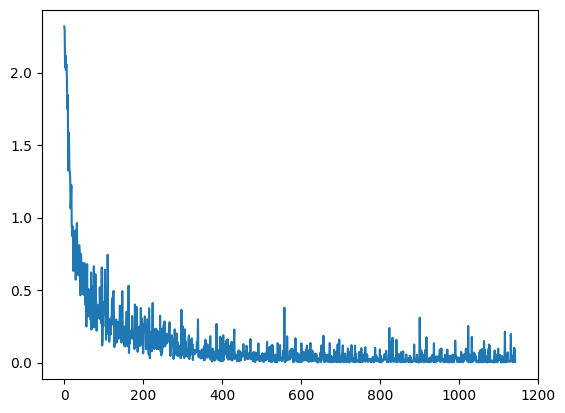

In [32]:
# XE loss
plt.plot(range(len(ll_c)), ll_c)

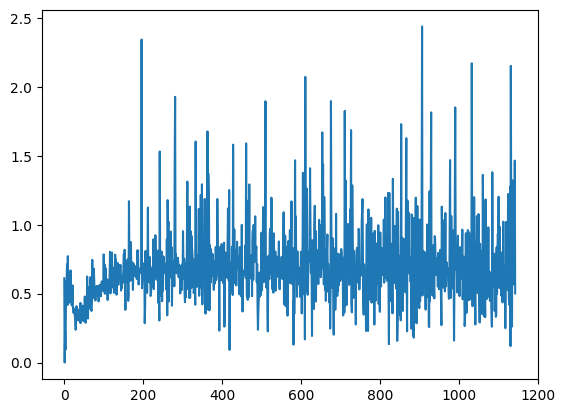

In [33]:
# Discriminator loss
plt.plot(range(len(ll_d)), ll_d)

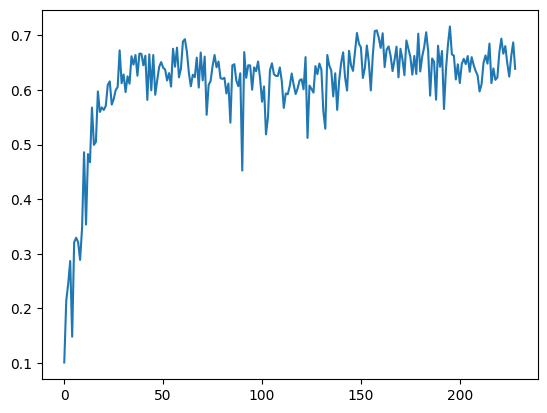

In [34]:
# Accuracy
plt.plot(range(len(acc_lst)), acc_lst)

In [35]:
max(acc_lst)

0.7163

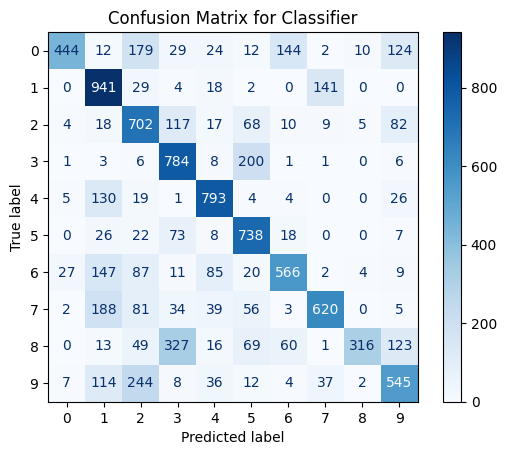

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Set models to evaluation mode
F.eval()
C.eval()

all_preds = []
all_labels = []

# Run on test data
with torch.no_grad():
    for data, labels in test_loader:  # Replace with your actual test DataLoader
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        # Forward pass through feature extractor and classifier
        features = F(data)
        outputs = C(features)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Classifier")
plt.show()